### Problem Statement: 
You work in a startup that develops photo editing features for third party apps. You are assigned with a task of creating an editing feature that implements different art styles on people’s faces.

### Objective: 
To perform neural style transfer using PyTorch.

### Import the necessary library

In [14]:
# !pip install torch

In [15]:
# !pip install torchvision

In [16]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

### Check if CUDA is available

In [17]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

### Load a Vgg-19 model

In [18]:
model = models.vgg19(pretrained=True).features
for p in model.parameters():
    p.requires_grad = False
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Choose layers for style loss and content loss

In [19]:
def model_activations(input,model):
    layers = {
    '0' : 'conv1_1',
    '5' : 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '21': 'conv4_2',
    '28': 'conv5_1'
    }
    features = {}
    x = input
    x = x.unsqueeze(0)
    for name,layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x 
    
    return features

### Transform the images

In [20]:
transform = transforms.Compose([transforms.Resize(300),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) #using 0.5,0.5,0.5) for both mean and sd

In [21]:
content = Image.open("content.jpg").convert("RGB")
content = transform(content).to(device)
print("Content shape => ", content.shape)
style = Image.open("style.jpg").convert("RGB")
style = transform(style).to(device)

Content shape =>  torch.Size([3, 300, 427])


### Function to convert the image

In [22]:
def imcnvt(image):
    x = image.to("cpu").clone().detach().numpy().squeeze()
    x = x.transpose(1,2,0)
    x = x*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    x = np.clip(x, 0.0, 1.0)

    return x

### Print the image

In [23]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

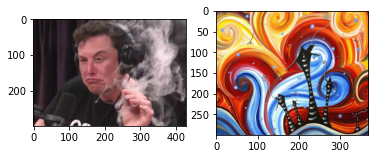

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2)

ax1.imshow(imcnvt(content),label = "Content")
ax2.imshow(imcnvt(style),label = "Style")
plt.show()

In [25]:
def gram_matrix(imgfeature):
    _,d,h,w = imgfeature.size()
    imgfeature = imgfeature.view(d,h*w)
    gram_mat = torch.mm(imgfeature,imgfeature.t())
    
    return gram_mat

In [26]:
target = content.clone().requires_grad_(True).to(device)

#set device to cuda if available
print("device = ",device)

device =  cpu


In [27]:
style_features = model_activations(style,model)
content_features = model_activations(content,model)

style_wt_meas = {"conv1_1" : 1.0, 
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.4,
                 "conv4_1" : 0.2,
                 "conv5_1" : 0.1}

style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features}

epoch  10   tensor(1.1509e+18, grad_fn=<AddBackward0>)
epoch  20   tensor(8.6213e+17, grad_fn=<AddBackward0>)


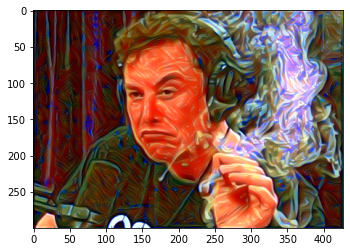

epoch  30   tensor(6.3719e+17, grad_fn=<AddBackward0>)
epoch  40   tensor(4.7780e+17, grad_fn=<AddBackward0>)


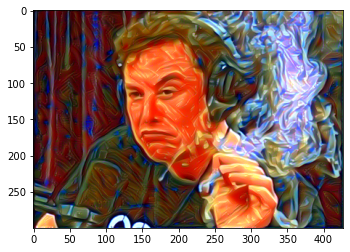

epoch  50   tensor(3.7371e+17, grad_fn=<AddBackward0>)
epoch  60   tensor(3.0472e+17, grad_fn=<AddBackward0>)


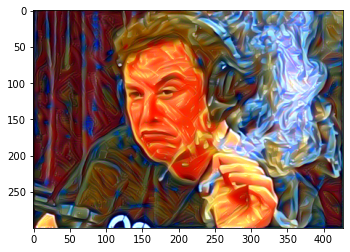

epoch  70   tensor(2.5608e+17, grad_fn=<AddBackward0>)
epoch  80   tensor(2.2116e+17, grad_fn=<AddBackward0>)


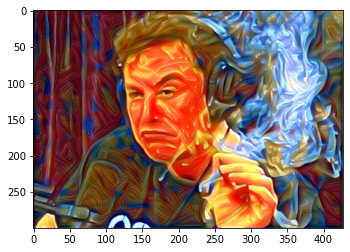

epoch  90   tensor(1.9535e+17, grad_fn=<AddBackward0>)
epoch  100   tensor(1.7564e+17, grad_fn=<AddBackward0>)


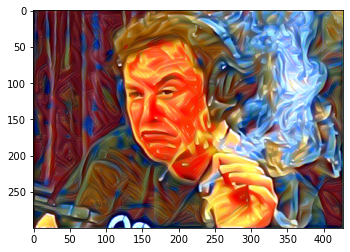

In [29]:
content_wt = 100
style_wt = 1e8

# print_after = 500
print_after = 20
# epochs = 2000
epochs = 100
optimizer = torch.optim.Adam([target],lr=0.007)

for i in range(1,epochs+1):
    target_features = model_activations(target,model)
    content_loss = torch.mean((content_features['conv4_2']-target_features['conv4_2'])**2)

    style_loss = 0
    for layer in style_wt_meas:
        style_gram = style_grams[layer]
        target_gram = target_features[layer]
        _,d,w,h = target_gram.shape
        target_gram = gram_matrix(target_gram)

        style_loss += (style_wt_meas[layer]*torch.mean((target_gram-style_gram)**2))/d*w*h
    
    total_loss = content_wt*content_loss + style_wt*style_loss 
    
    if i%10==0:       
        print("epoch ",i," ", total_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%print_after == 0:
        plt.imshow(imcnvt(target),label="Epoch "+str(i))
        plt.show()
        plt.imsave(str(i)+'.png',imcnvt(target),format='png')